In [1]:
# import libraries and packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor

# Data loading and visualization

In [2]:
# import dataset
# please download the dataset here: https://github.com/zhouhaoyi/ETDataset/tree/main/ETT-small
# df = pd.read_csv("ETTh1.csv")
df = pd.read_csv("https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv", on_bad_lines='skip')
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [ ]:
df.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,7.375141,2.242242,4.300239,0.881568,3.066062,0.856932,13.324672
std,7.067744,2.042342,6.826978,1.809293,1.164506,0.599552,8.566946
min,-22.705999,-4.756000,-25.087999,-5.934000,-1.188000,-1.371000,-4.080000
25%,5.827000,0.737000,3.296000,-0.284000,2.315000,0.670000,6.964000
50%,8.774000,2.210000,5.970000,0.959000,2.833000,0.975000,11.396000
75%,11.788000,3.684000,8.635000,2.203000,3.625000,1.218000,18.079000
max,23.643999,10.114000,17.341000,7.747000,8.498000,3.046000,46.007000


In [ ]:
# Check missing values in the original data:
df.isna().sum()

date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

In [ ]:
df.isnull().sum()

date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

In [ ]:
# Checking Data type of each column
print("Date column data type: ", type(df['date'][0]))
print("HUFL column data type: ", type(df['HUFL'][0]))
print("HULL column data type: ", type(df['HULL'][0]))
print("MUFL column data type: ", type(df['MUFL'][0]))
print("MULL column data type: ", type(df['MULL'][0]))
print("LUFL column data type: ", type(df['LUFL'][0]))
print("LULL column data type: ", type(df['LULL'][0]))
print("OT column data type: ", type(df['OT'][0]))

Date column data type:  <class 'str'>
HUFL column data type:  <class 'numpy.float64'>
HULL column data type:  <class 'numpy.float64'>
MUFL column data type:  <class 'numpy.float64'>
MULL column data type:  <class 'numpy.float64'>
LUFL column data type:  <class 'numpy.float64'>
LULL column data type:  <class 'numpy.float64'>
OT column data type:  <class 'numpy.float64'>


In [3]:
# Convert date field from string to Date format and make it index
df['date'] = pd.to_datetime(df.date)
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [ ]:
print("Starting date: ",df.iloc[0][0])
print("Ending date: ", df.iloc[-1][0])
print("Duration: ", df.iloc[-1][0]-df.iloc[0][0])

Starting date:  2016-07-01 00:00:00
Ending date:  2018-06-26 19:00:00
Duration:  725 days 19:00:00


In [4]:
ot = df[['date','OT']]
ot.head()

,date,OT
0,2016-07-01 00:00:00,30.531000
1,2016-07-01 01:00:00,27.787001
2,2016-07-01 02:00:00,27.787001
3,2016-07-01 03:00:00,25.044001
4,2016-07-01 04:00:00,21.948000


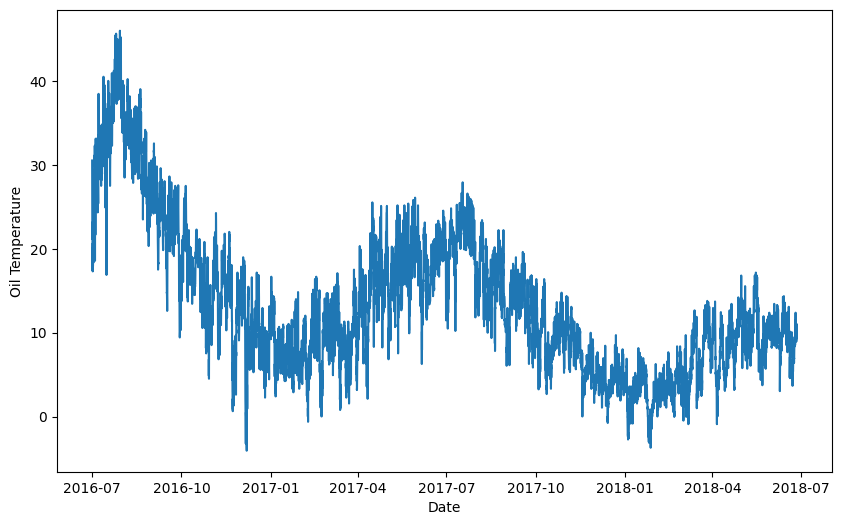

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(ot['date'], ot['OT'])
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.show()

## Pure features and Ot with features dataset

In [ ]:
### doesn't need create dataset
ot_feature_only = df
ot_feature_only = df[['HUFL',	'HULL',	'MUFL',	'MULL',	'LUFL',	'LULL']]
training_size=int(len(ot_feature_only)*0.7)
test_size=len(ot_feature_only)-training_size
train_data_f_only = ot_feature_only[0:training_size]
test_data_f_only = ot_feature_only[training_size:len(ot_feature_only)]

In [ ]:
ot_feature = df
ot_feature.head()
ot_f = ot_feature.copy()
del ot_f['date']
training_size=int(len(ot_f)*0.7)
test_size=len(ot_f)-training_size
train_data_f = ot_f[0:training_size]
test_data_f = ot_f[training_size:len(ot_f)]

ot_f_date = ot_feature.copy()
del ot_f_date['OT']
train_date_f = np.array(ot_f_date[0:training_size]).flatten()
test_date_f = np.array(ot_f_date[training_size:len(ot_f_date)]).flatten()

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
train_set_f = scaler.fit_transform(np.array(train_data_f).reshape(-1,7))
test_set_f = scaler.transform(np.array(test_data_f).reshape(-1,7))

In [ ]:
def create_dataset_f(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)-1,6].flatten()
        
        a= np.append(a,np.array((dataset[i+time_step,0:5].flatten())))
        dataX.append(a)
        
        dataY.append(dataset[i + time_step][6])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 14
X_train_f, y_train_f = create_dataset_f(train_set_f, time_step)
X_test_f, y_test_f = create_dataset_f(test_set_f, time_step)

print("X_train_f: ", X_train_f.shape)
print("y_train_f: ", y_train_f.shape)
print("X_test_f: ", X_test_f.shape)
print("y_test_f", y_test_f.shape)

X_train_f:  (12179, 18)
y_train_f:  (12179,)
X_test_f:  (5211, 18)
y_test_f (5211,)


Incremental Prediction for long term prediction

In [ ]:
def increamental_prediction(test_data,time_step,model_predict,periods=1):
  
  result = []
  #store = []
  for p in range(len(test_data_cur)/periods):
    test_data_cur=test_data[p].reshape(1,-1)
    test_data_cur = np.array(test_data_cur)
    for j in range(periods):

      #print("ori",test_data)
      cur = model_predict(test_data_cur)
      #print("pred",cur)
      test_data_temp = test_data_cur
      test_data_cur = test_data[p*periods+j].reshape(1,-1)
      test_data_cur = np.array(test_data_cur)
      for i in range(time_step-1):
        test_data_cur[0,i]= test_data_temp[0,i+1]
      test_data_cur[0,time_step-1] = cur
    
      #print("now",test_data)
      result.append(cur)
      #store.append([test_data])

  return np.array(result)
def multiprediction(test_data,time_step,model_predict)

# Time series analysis

In [ ]:
df_analysis = df
df_analysis['date'] = pd.to_datetime(df.date)

df_analysis.index = pd.to_datetime(df_analysis['date'])
df_analysis = df_analysis.drop(['date'], axis=1)

**Analysis of a week**

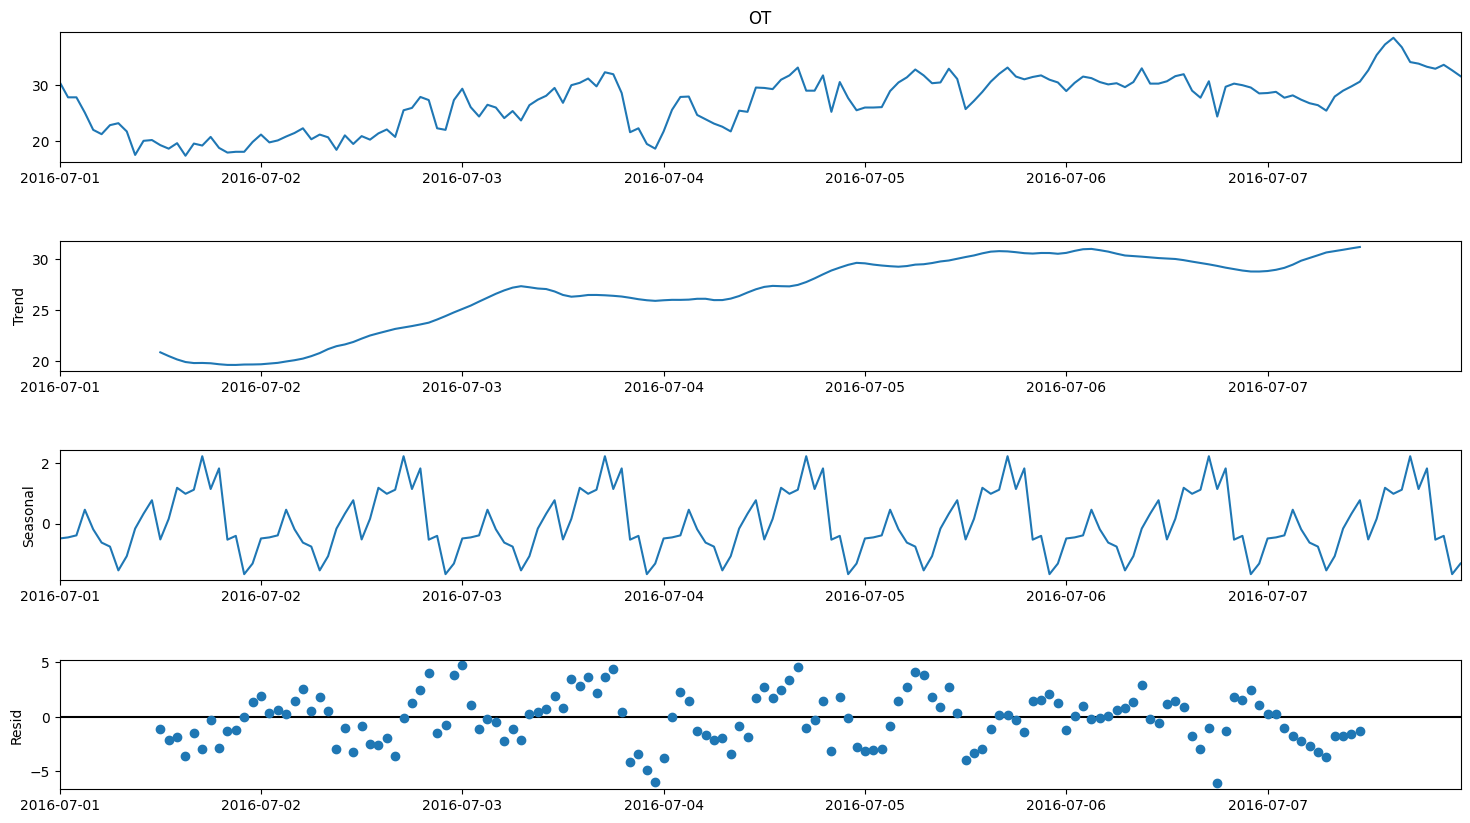

In [ ]:
df_analysis_week = df_analysis[0:7*24]
result = sm.tsa.seasonal_decompose(df_analysis_week['OT'], model='additive')
fig = result.plot()
fig.set_size_inches((16,9))
plt.show()


**Analysis of a month**

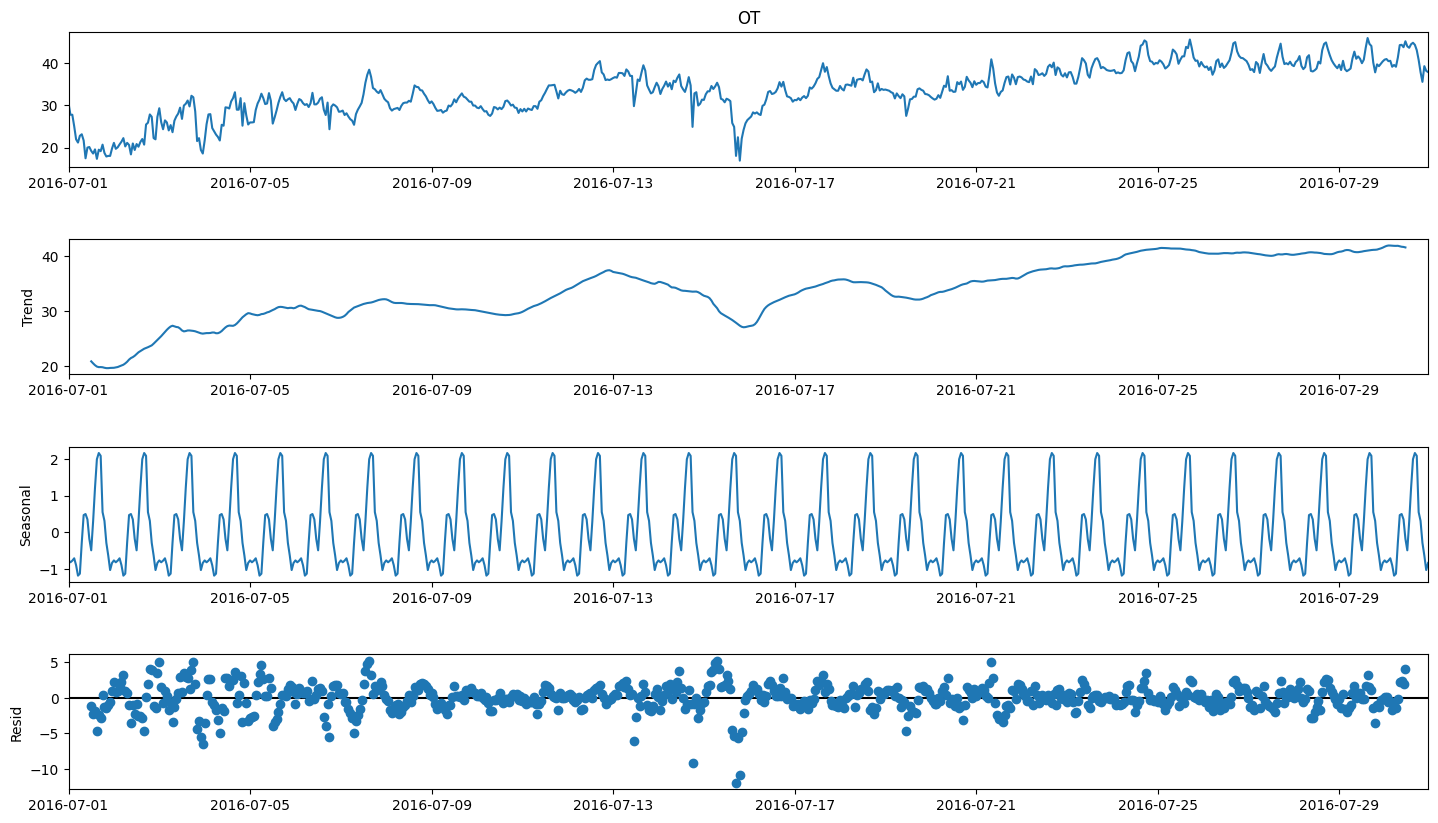

In [ ]:
df_analysis_month = df_analysis[0:720]
result = sm.tsa.seasonal_decompose(df_analysis_month['OT'], model='additive')
fig = result.plot()
fig.set_size_inches((16,9))
plt.show()

Analysis of full period


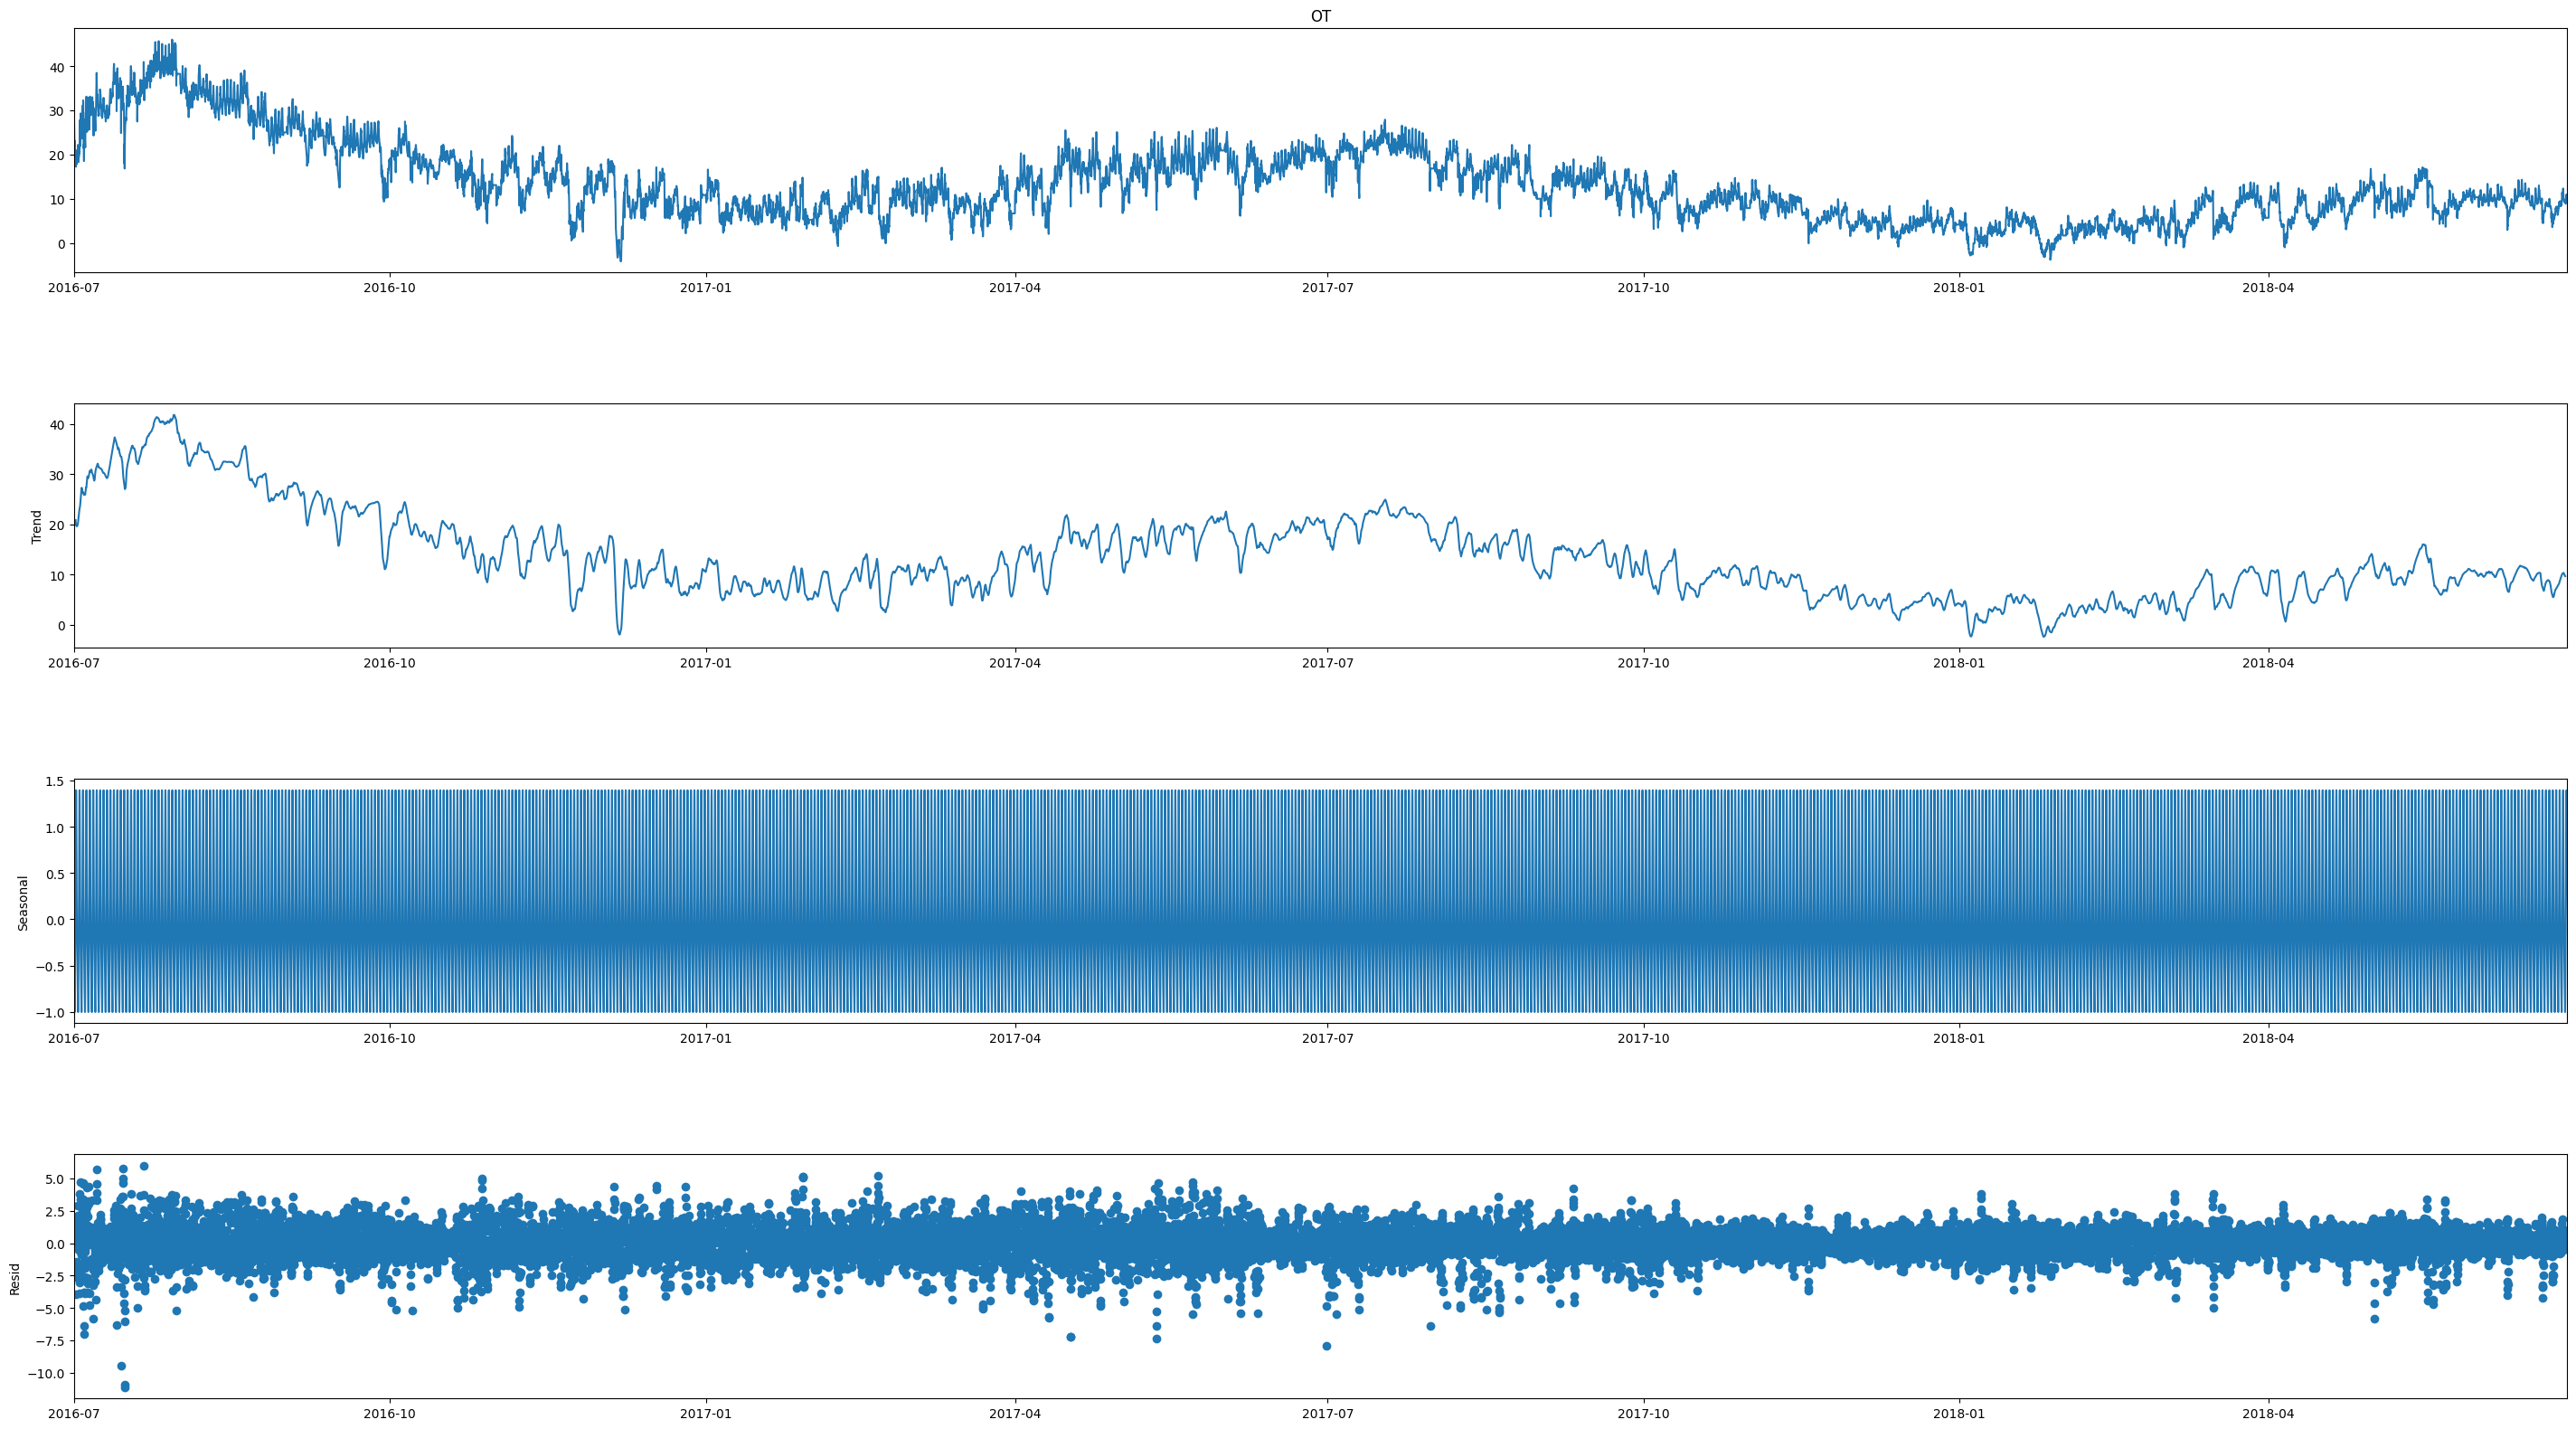

In [ ]:
result = sm.tsa.seasonal_decompose(df_analysis['OT'], model='additive')
fig = result.plot()
fig.set_size_inches((32, 18))
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['OT'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -3.487963577593398
p-value: 0.008301649485465485
Critical Values:
1%: -3.4307264182079904
5%: -2.8617063622340195
10%: -2.566858550311889


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


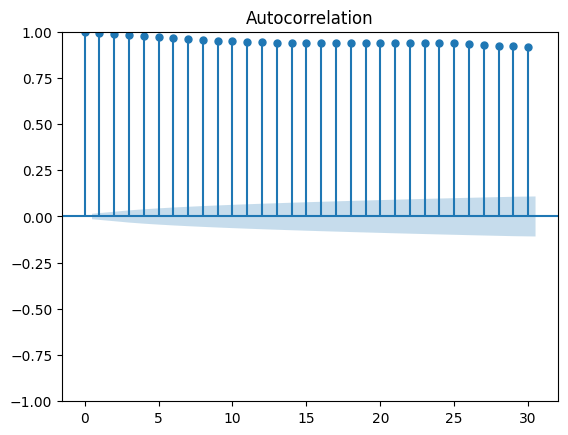

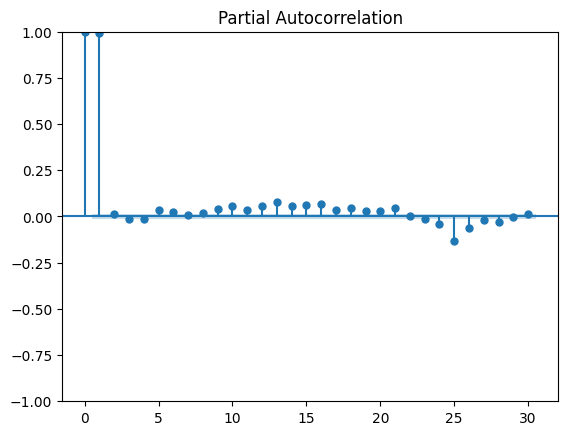

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_analysis['OT'], lags=30)
plot_pacf(df_analysis['OT'], lags=30)
plt.show()

# Evaluation

In [5]:
def evaluation(true, pred):
    print("RMSE: ", math.sqrt(mean_squared_error(true,pred)))
    print("MSE: ", mean_squared_error(true,pred))
    print("MAE: ", mean_absolute_error(true,pred))
    print("R2: ", r2_score(true,pred))
    return pd.DataFrame({'RMSE':[math.sqrt(mean_squared_error(true,pred))],'MSE': [mean_squared_error(true,pred)],'MAE':[mean_absolute_error(true,pred)],'R2':[r2_score(true,pred)]})

Utilize one-step prediction ml methods to generate a sequence of consecutive forecast

In [ ]:
def increamental_prediction(test_data,time_step,model_predict,periods=1):
  
  result = []
  #store = []
  for p in range(int(test_data.shape[0]/periods)):
    test_data_cur=test_data[p*periods].reshape(1,-1)
    test_data_cur = np.array(test_data_cur)
    for j in range(periods):

      #print("ori",test_data)
      cur = model_predict(test_data_cur)
      #print("pred",cur)
      test_data_temp = test_data_cur
      test_data_cur = test_data[p*periods+j].reshape(1,-1)
      test_data_cur = np.array(test_data_cur)
      for i in range(time_step-1):
        test_data_cur[0,i]= test_data_temp[0,i+1]
      test_data_cur[0,time_step-1] = cur
    
      #print("now",test_data)
      result.append(cur)
      #store.append([test_data])

  return np.array(result)

# Data Preprocessing: Train-Test Split 

In [6]:
ot_pre = ot.copy()
del ot_pre['date']
training_size=int(len(ot_pre)*0.7)
test_size=len(ot_pre)-training_size
train_data = ot_pre[0:training_size]
test_data = ot_pre[training_size:len(ot_pre)]

date_pre = ot.copy()
del date_pre['OT']
train_date = np.array(date_pre[0:training_size]).flatten()
test_date = np.array(date_pre[training_size:len(date_pre)]).flatten()

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
train_set = scaler.fit_transform(np.array(train_data).reshape(-1,1)).flatten()
test_set = scaler.transform(np.array(test_data).reshape(-1,1)).flatten()

In [8]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

In [9]:
time_step = 14
X_train, y_train = create_dataset(train_set, time_step)
X_test, y_test = create_dataset(test_set, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (12179, 14)
y_train:  (12179,)
X_test:  (5211, 14)
y_test (5211,)


# Traditional Machine Learning Models

## Support Vector Regression (SVM)

In [ ]:
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
model.fit(X_train, y_train)
# SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
#     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1,1)).flatten()
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1,1)).flatten()
y_train_draw = scaler.inverse_transform(y_train.reshape(-1,1)).flatten()
y_test_draw = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
print(y_train_draw.shape)

(12179,)


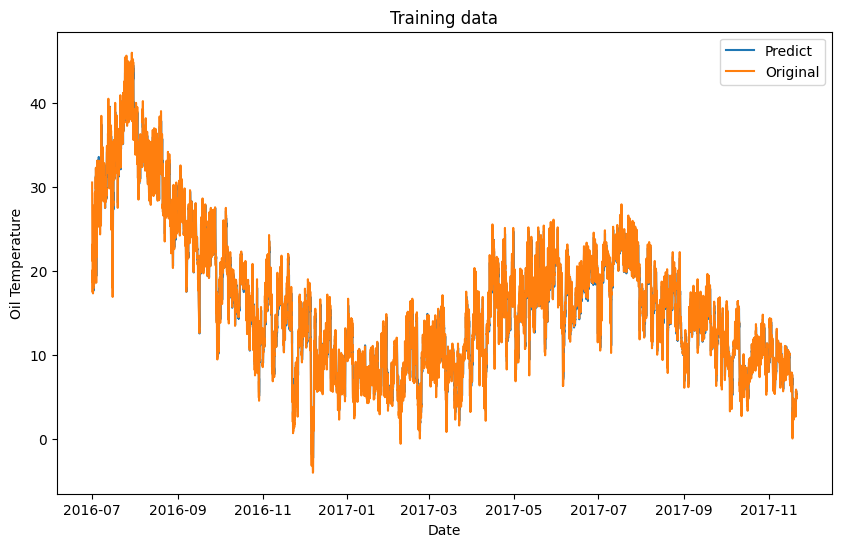

RMSE:  1.0309980492051798
MSE:  1.0629569774648864
MAE:  0.7331811572972434
R2:  0.9847517013293531


In [ ]:

y_train_pred_draw = np.empty(len(y_train_pred)+time_step+1)
y_train_pred_draw[:] = np.nan
y_train_pred_draw[time_step+1:len(y_train_pred_draw)+time_step+1] = y_train_pred

plt.figure(figsize=(10,6))
plt.plot(train_date, y_train_pred_draw, label= 'Predict')
plt.plot(train_date, np.array(train_data)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Training data")
plt.legend()
plt.show()

evaluation(y_train_draw, y_train_pred)

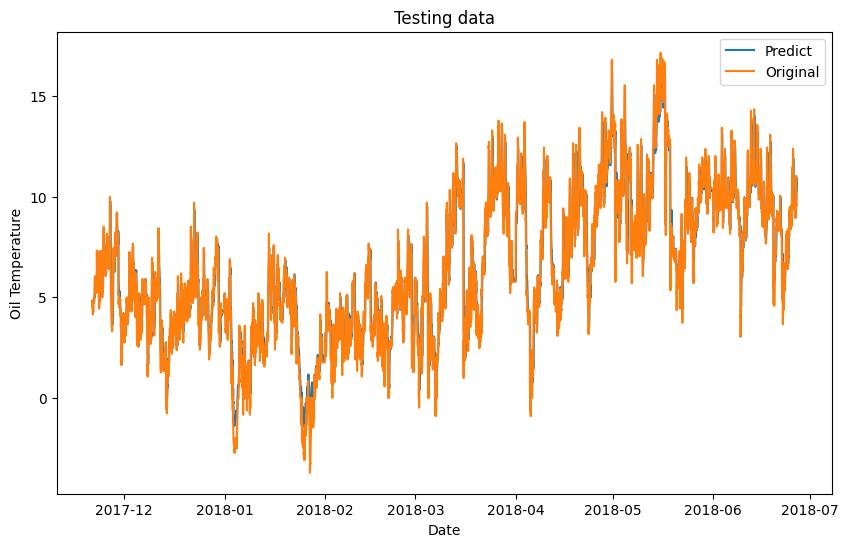

RMSE:  0.678055773160543
MSE:  0.4597596315163417
MAE:  0.4886527054934653
R2:  0.9657401153270404


In [ ]:
y_test_pred_draw = np.empty(len(y_test_pred)+time_step+1)
y_test_pred_draw[:] = np.nan
y_test_pred_draw[time_step+1:len(y_test_pred_draw)+time_step+1] = y_test_pred

plt.figure(figsize=(10,6))
plt.plot(test_date, y_test_pred_draw, label= 'Predict')
plt.plot(test_date, np.array(test_data)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Testing data")
plt.legend()
plt.show()

evaluation(y_test_draw, y_test_pred)

In [ ]:
result_svm = pd.DataFrame(columns=['RMSE', 'MSE', 'MAE', 'R2'])

periods = [1,2,4,12,24,48]
for i in range(6):

  y_test_pred1 = increamental_prediction(X_test,time_step,model.predict,periods[i])
  y_test_pred1 = scaler.inverse_transform(y_test_pred1.reshape(-1,1)).flatten()

  y_test_pred_draw1 = np.empty(len(y_test_pred1)+time_step+1)
  y_test_pred_draw1[:] = np.nan
  y_test_pred_draw1[time_step+1:len(y_test_pred_draw)+time_step+1] = y_test_pred1
  
  y_test_draw1 =  y_test_draw[:y_test_pred1.shape[0]]
  result_svm = pd.concat([result_svm, evaluation(y_test_draw1, y_test_pred1)], ignore_index=True)

test_date1= test_date[:y_test_pred_draw1.shape[0]]
test_data1= test_data[:y_test_pred_draw1.shape[0]]
plt.figure(figsize=(10,6))
plt.plot(test_date1, y_test_pred_draw1, label= 'Predict')
plt.plot(test_date1, np.array(test_data1)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Testing data")
plt.legend()
plt.show()
result_svm

## Random Forest Regressor (RF)

In [ ]:

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score


# Define the hyperparameters to tune
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid for hyperparameters
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Create a random forest regressor with default hyperparameters
rf_def = RandomForestRegressor()

# Perform RandomizedSearchCV to find the best hyperparameters
rf_random = RandomizedSearchCV(estimator = rf_def, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters: ", rf_random.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Hyperparameters:  {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}


In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters: ", rf_random.best_params_)

Best Hyperparameters:  {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}


In [ ]:
# Use the best hyperparameters to train the random forest model
RF = RandomForestRegressor(n_estimators = 100,
                          min_samples_split = rf_random.best_params_['min_samples_split'],
                          min_samples_leaf = rf_random.best_params_['min_samples_leaf'],
                          max_features = rf_random.best_params_['max_features'],
                          max_depth = rf_random.best_params_['max_depth'],
                          bootstrap = rf_random.best_params_['bootstrap'])
RF.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Training Error: 
MAE 0.006398610235604213
MSE 9.761950440654068e-05
R2: 0.996486885216486
Adjusted R2: 0.9964828418420228
------------------
Evaluation Error: 
MAE 0.014155886762825302
MSE: 0.00035288867027654264
R2: 0.9340305574606583
Adjusted R2: 0.933852810694771


In [ ]:
# RF = RandomForestRegressor(n_estimators = 100, random_state = 0)
# RF.fit(X_train, y_train)
y_train_pred=RF.predict(X_train)
y_test_pred=RF.predict(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1,1)).flatten()
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1,1)).flatten()

y_train_draw = scaler.inverse_transform(y_train.reshape(-1,1)).flatten()
y_test_draw = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

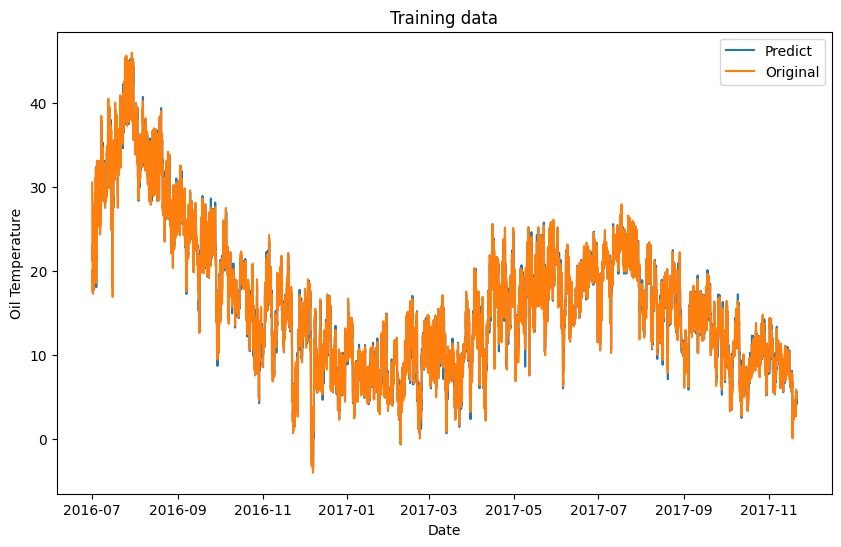

RMSE:  0.49487249725784355
MSE:  0.2448987885422144
MAE:  0.32048719018726296
R2:  0.996486885216486


In [ ]:
y_train_pred_draw = np.empty(len(y_train_pred)+time_step+1)
y_train_pred_draw[:] = np.nan
y_train_pred_draw[time_step+1:len(y_train_pred_draw)+time_step+1] = y_train_pred

plt.figure(figsize=(10,6))
plt.plot(train_date, y_train_pred_draw, label= 'Predict')
plt.plot(train_date, np.array(train_data)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Training data")
plt.legend()
plt.show()

evaluation(y_train_draw, y_train_pred)

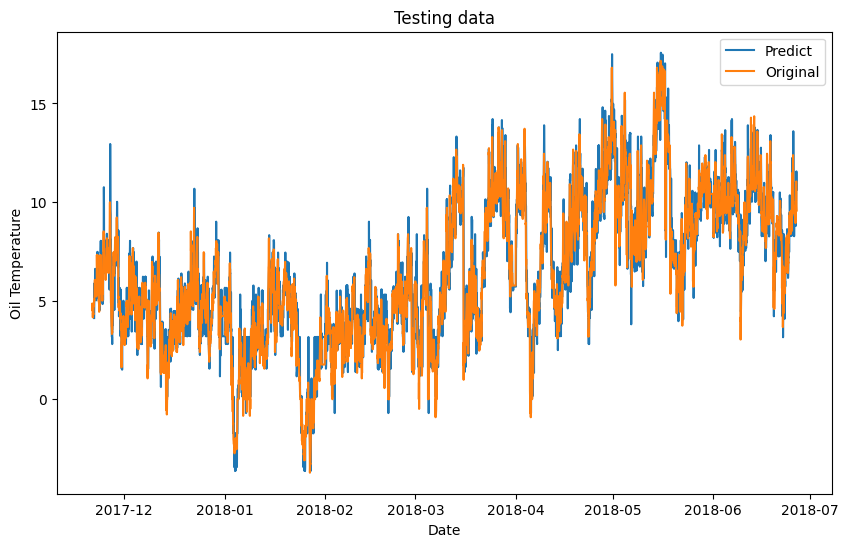

RMSE:  0.9409008844513282
MSE:  0.8852944743612917
MAE:  0.7090258987776191
R2:  0.9340305574606583


In [ ]:
y_test_pred_draw = np.empty(len(y_test_pred)+time_step+1)
y_test_pred_draw[:] = np.nan
y_test_pred_draw[time_step+1:len(y_test_pred_draw)+time_step+1] = y_test_pred

plt.figure(figsize=(10,6))
plt.plot(test_date, y_test_pred_draw, label= 'Predict')
plt.plot(test_date, np.array(test_data)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Testing data")
plt.legend()
plt.show()

evaluation(y_test_draw, y_test_pred)

In [ ]:
result_rf = pd.DataFrame(columns=['RMSE', 'MSE', 'MAE', 'R2'])

periods = [1,2,4,12,24,48]
for i in range(6):

  y_test_pred1 = increamental_prediction(X_test,time_step,RF.predict,periods[i])
  y_test_pred1 = scaler.inverse_transform(y_test_pred1.reshape(-1,1)).flatten()

  y_test_pred_draw1 = np.empty(len(y_test_pred1)+time_step+1)
  y_test_pred_draw1[:] = np.nan
  y_test_pred_draw1[time_step+1:len(y_test_pred_draw)+time_step+1] = y_test_pred1
  
  y_test_draw1 =  y_test_draw[:y_test_pred1.shape[0]]
  result_rf = pd.concat([result_svm, evaluation(y_test_draw1, y_test_pred1)], ignore_index=True)

test_date1= test_date[:y_test_pred_draw1.shape[0]]
test_data1= test_data[:y_test_pred_draw1.shape[0]]
plt.figure(figsize=(10,6))
plt.plot(test_date1, y_test_pred_draw1, label= 'Predict')
plt.plot(test_date1, np.array(test_data1)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Testing data")
plt.legend()
plt.show()
result_svm

## K-nearest Neighbour (KNN)

In [ ]:
K = time_step
neighbor = neighbors.KNeighborsRegressor(n_neighbors = K)
neighbor.fit(X_train, y_train)

y_train_pred=neighbor.predict(X_train)
y_test_pred=neighbor.predict(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1,1)).flatten()
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1,1)).flatten()

y_train_draw = scaler.inverse_transform(y_train.reshape(-1,1)).flatten()
y_test_draw = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

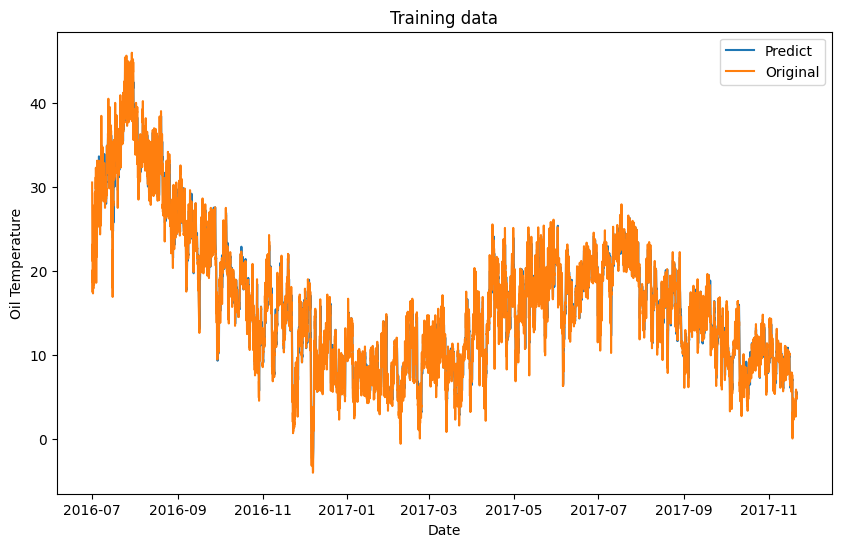

RMSE:  1.0651325330327088
MSE:  1.1345073129246748
MAE:  0.7530075536981118
R2:  0.9837252995951287


In [ ]:
y_train_pred_draw = np.empty(len(y_train_pred)+time_step+1)
y_train_pred_draw[:] = np.nan
y_train_pred_draw[time_step+1:len(y_train_pred_draw)+time_step+1] = y_train_pred

plt.figure(figsize=(10,6))
plt.plot(train_date, y_train_pred_draw, label= 'Predict')
plt.plot(train_date, np.array(train_data)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Training data")
plt.legend()
plt.show()

evaluation(y_train_draw, y_train_pred)

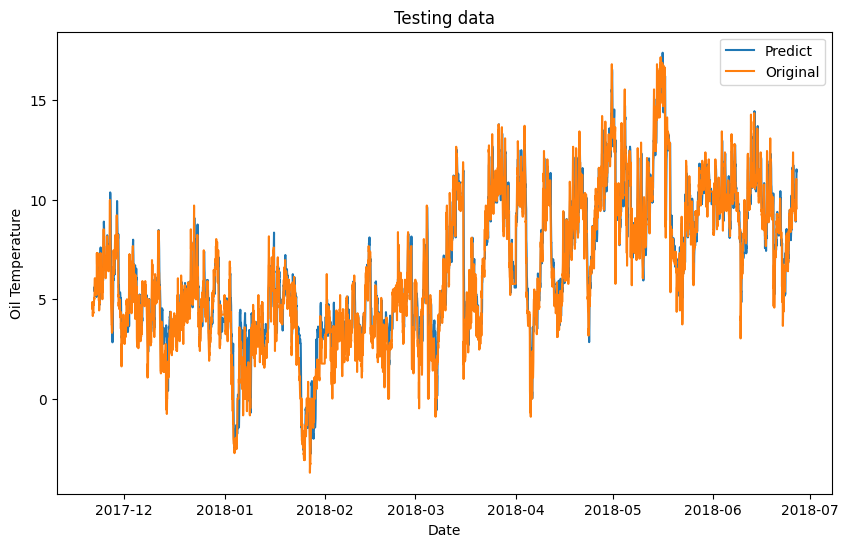

RMSE:  0.931140074717569
MSE:  0.8670218387450399
MAE:  0.6851097895400573
R2:  0.9353921785034174


In [ ]:
y_test_pred_draw = np.empty(len(y_test_pred)+time_step+1)
y_test_pred_draw[:] = np.nan
y_test_pred_draw[time_step+1:len(y_test_pred_draw)+time_step+1] = y_test_pred

plt.figure(figsize=(10,6))
plt.plot(test_date, y_test_pred_draw, label= 'Predict')
plt.plot(test_date, np.array(test_data)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Testing data")
plt.legend()
plt.show()

evaluation(y_test_draw, y_test_pred)

In [ ]:
result_knn = pd.DataFrame(columns=['RMSE', 'MSE', 'MAE', 'R2'])

periods = [1,2,4,12,24,48]
for i in range(6):

  y_test_pred1 = increamental_prediction(X_test,time_step,neighbor.predict,periods[i])
  y_test_pred1 = scaler.inverse_transform(y_test_pred1.reshape(-1,1)).flatten()

  y_test_pred_draw1 = np.empty(len(y_test_pred1)+time_step+1)
  y_test_pred_draw1[:] = np.nan
  y_test_pred_draw1[time_step+1:len(y_test_pred_draw)+time_step+1] = y_test_pred1
  
  y_test_draw1 =  y_test_draw[:y_test_pred1.shape[0]]
  result_knn = pd.concat([result_svm, evaluation(y_test_draw1, y_test_pred1)], ignore_index=True)

test_date1= test_date[:y_test_pred_draw1.shape[0]]
test_data1= test_data[:y_test_pred_draw1.shape[0]]
plt.figure(figsize=(10,6))
plt.plot(test_date1, y_test_pred_draw1, label= 'Predict')
plt.plot(test_date1, np.array(test_data1)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Testing data")
plt.legend()
plt.show()
result_knn

# Deep Learning Models

## RNN



In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (12179, 14, 1)
X_test:  (5211, 14, 1)


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        
        self.rnn1 = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True, dropout=0.2)
        self.rnn2 = nn.RNN(input_size=hidden_dim, hidden_size=hidden_dim//2, num_layers=1, batch_first=True, dropout=0.2)
        self.rnn3 = nn.RNN(input_size=hidden_dim//2, hidden_size=hidden_dim//8, num_layers=1, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim//8, output_dim)
        
    def forward(self, x):
        out, _ = self.rnn1(x)
        out, _ = self.rnn2(out)
        out, _ = self.rnn3(out)
        out = self.fc(out[:, -1, :])
        out = torch.sigmoid(out)
        return out


# Define the model
model = RNN(input_dim=1, hidden_dim=128, output_dim=1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))
    loss.backward()
    optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    score = criterion(outputs, y_test_tensor.unsqueeze(1))
    print('Test loss:', score.item())


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/100], Loss: 0.0322
Epoch [2/100], Loss: 0.0278
Epoch [3/100], Loss: 0.0281
Epoch [4/100], Loss: 0.0270
Epoch [5/100], Loss: 0.0254
Epoch [6/100], Loss: 0.0243
Epoch [7/100], Loss: 0.0235
Epoch [8/100], Loss: 0.0223
Epoch [9/100], Loss: 0.0198
Epoch [10/100], Loss: 0.0164
Epoch [11/100], Loss: 0.0130
Epoch [12/100], Loss: 0.0084
Epoch [13/100], Loss: 0.0042
Epoch [14/100], Loss: 0.0042
Epoch [15/100], Loss: 0.0070
Epoch [16/100], Loss: 0.0072
Epoch [17/100], Loss: 0.0072
Epoch [18/100], Loss: 0.0046
Epoch [19/100], Loss: 0.0035
Epoch [20/100], Loss: 0.0030
Epoch [21/100], Loss: 0.0033
Epoch [22/100], Loss: 0.0042
Epoch [23/100], Loss: 0.0045
Epoch [24/100], Loss: 0.0044
Epoch [25/100], Loss: 0.0043
Epoch [26/100], Loss: 0.0038
Epoch [27/100], Loss: 0.0030
Epoch [28/100], Loss: 0.0027
Epoch [29/100], Loss: 0.0026
Epoch [30/100], Loss: 0.0025
Epoch [31/100], Loss: 0.0029
Epoch [32/100], Loss: 0.0030
Epoch [33/100], Loss: 0.0028
Epoch [34/100], Loss: 0.0027
Epoch [35/100], Loss: 0

In [ ]:
# Predict on train and test sets
y_train_pred = model(torch.Tensor(X_train)).detach().numpy()
y_test_pred = model(torch.Tensor(X_test)).detach().numpy() 

y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1,1)).flatten()
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1,1)).flatten()

y_train_draw = scaler.inverse_transform(y_train.reshape(-1,1)).flatten()
y_test_draw = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

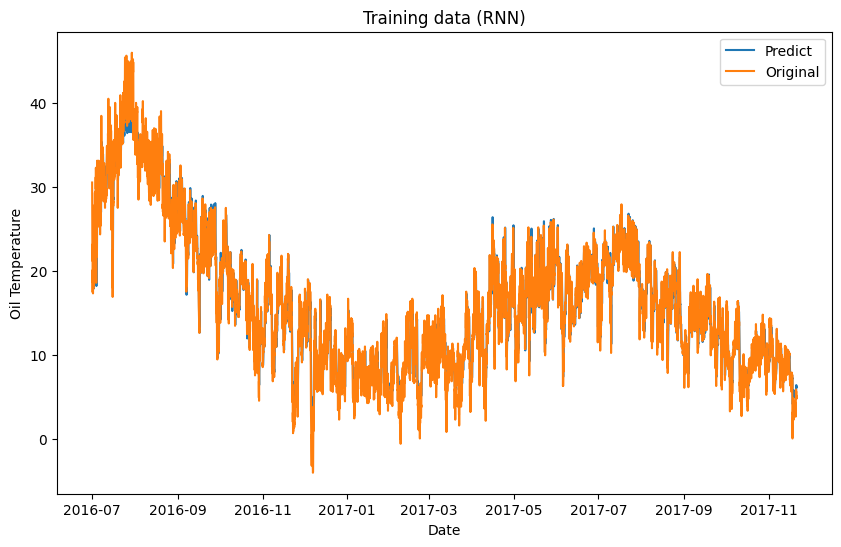

RMSE:  1.5886813950957177
MSE:  2.523908575123276
MAE:  1.1584824261083735
R2:  0.9637941021256826


In [ ]:
y_train_pred_draw = np.empty(len(y_train_pred)+time_step+1)
y_train_pred_draw[:] = np.nan
y_train_pred_draw[time_step+1:len(y_train_pred_draw)+time_step+1] = y_train_pred

plt.figure(figsize=(10,6))
plt.plot(train_date, y_train_pred_draw, label= 'Predict')
plt.plot(train_date, np.array(train_data)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Training data (RNN)")
plt.legend()
plt.show()

evaluation(y_train_draw, y_train_pred)

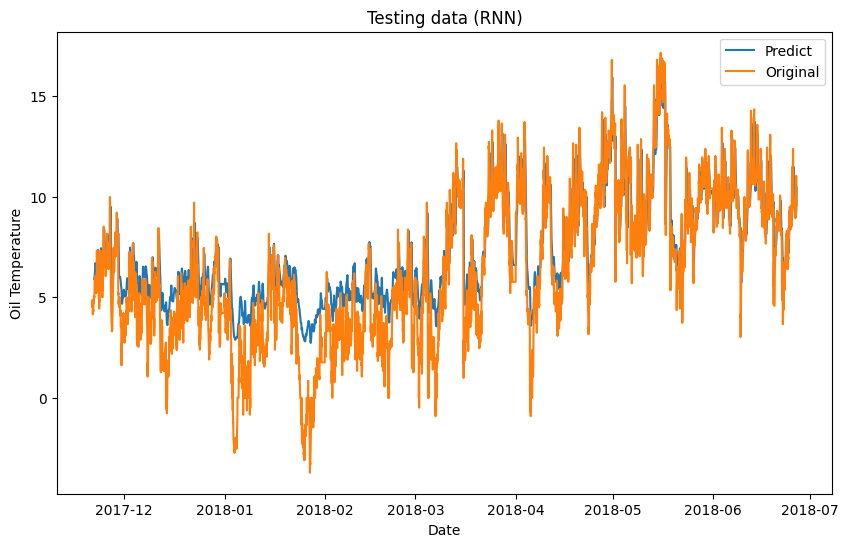

RMSE:  1.7322021105476164
MSE:  3.000524151785617
MAE:  1.3240586337716538
R2:  0.7764100970336035


In [ ]:
y_test_pred_draw = np.empty(len(y_test_pred)+time_step+1)
y_test_pred_draw[:] = np.nan
y_test_pred_draw[time_step+1:len(y_test_pred_draw)+time_step+1] = y_test_pred

plt.figure(figsize=(10,6))
plt.plot(test_date, y_test_pred_draw, label= 'Predict')
plt.plot(test_date, np.array(test_data)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Testing data (RNN)")
plt.legend()
plt.show()

evaluation(y_test_draw, y_test_pred)

## GRU

In [10]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Define the Bidirectional GRU model
class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) # Initialize hidden state with zeros
        out, _ = self.gru(x, h0) # Forward propagate GRU
        out = self.fc(out[:, -1, :]) # Decode the hidden state of the last time step
        return out

# Create the model
seq_length = time_step # Sequence length
input_size = 1 # Number of features
hidden_size = 64 # Number of hidden units in each layer
num_layers = 4 # Number of layers
output_size = 1 # Number of output units
learning_rate = 0.005 # Learning rate
num_epochs = 100
batch_size = 5
model = BiGRU(input_size, hidden_size, num_layers, output_size).to(device)
model.train()
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size)

for epoch in range(num_epochs):
    train_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    with torch.no_grad():
        test_loss = 0
        for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
        test_loss /= len(test_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/100, Train Loss: 0.0043, Test Loss: 0.0013
Epoch 2/100, Train Loss: 0.0011, Test Loss: 0.0006
Epoch 3/100, Train Loss: 0.0008, Test Loss: 0.0007
Epoch 4/100, Train Loss: 0.0007, Test Loss: 0.0006
Epoch 5/100, Train Loss: 0.0007, Test Loss: 0.0005
Epoch 6/100, Train Loss: 0.0007, Test Loss: 0.0005
Epoch 7/100, Train Loss: 0.0007, Test Loss: 0.0005
Epoch 8/100, Train Loss: 0.0007, Test Loss: 0.0006
Epoch 9/100, Train Loss: 0.0007, Test Loss: 0.0006
Epoch 10/100, Train Loss: 0.0007, Test Loss: 0.0006
Epoch 11/100, Train Loss: 0.0007, Test Loss: 0.0006
Epoch 12/100, Train Loss: 0.0006, Test Loss: 0.0005
Epoch 13/100, Train Loss: 0.0006, Test Loss: 0.0005
Epoch 14/100, Train Loss: 0.0006, Test Loss: 0.0005
Epoch 15/100, Train Loss: 0.0006, Test Loss: 0.0005
Epoch 16/100, Train Loss: 0.0006, Test Loss: 0.0005
Epoch 17/100, Train Loss: 0.0006, Test Loss: 0.0005
Epoch 18/100, Train Loss: 0.0006, Test Loss: 0.0005
Epoch 19/100, Train Loss: 0.0006, Test Loss: 0.0005
Epoch 20/100, Train L

In [13]:
y_train_pred = model(torch.Tensor(X_train).to(device)).detach().cpu().numpy()
y_test_pred = model(torch.Tensor(X_test).to(device)).detach().cpu().numpy() 

y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1,1)).flatten()
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1,1)).flatten()

y_train_draw = scaler.inverse_transform(y_train.reshape(-1,1)).flatten()
y_test_draw = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

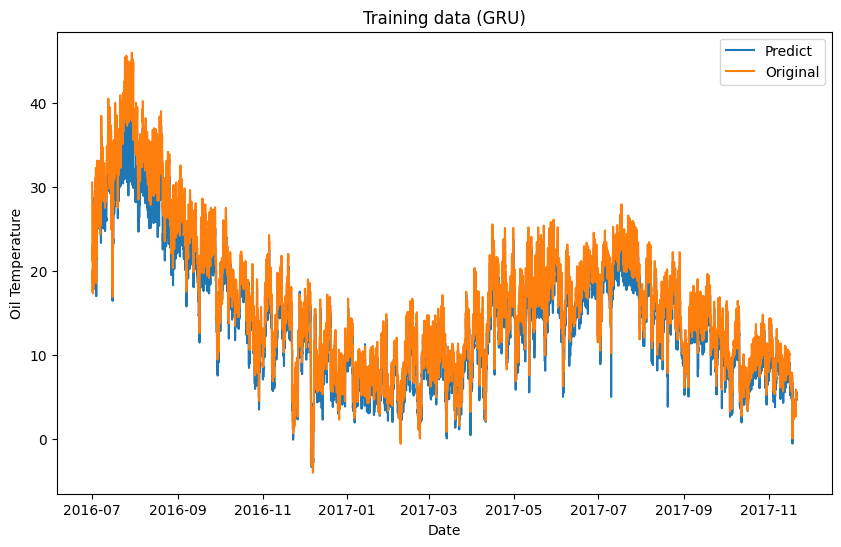

RMSE:  2.041541883947697
MSE:  4.1678932639127115
MAE:  1.6539715767923477
R2:  0.9402108620923766


,RMSE,MSE,MAE,R2
0,2.041542,4.167893,1.653972,0.940211


In [14]:
y_train_pred_draw = np.empty(len(y_train_pred)+time_step+1)
y_train_pred_draw[:] = np.nan
y_train_pred_draw[time_step+1:len(y_train_pred_draw)+time_step+1] = y_train_pred

plt.figure(figsize=(10,6))
plt.plot(train_date, y_train_pred_draw, label= 'Predict')
plt.plot(train_date, np.array(train_data)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Training data (GRU)")
plt.legend()
plt.show()

evaluation(y_train_draw, y_train_pred)

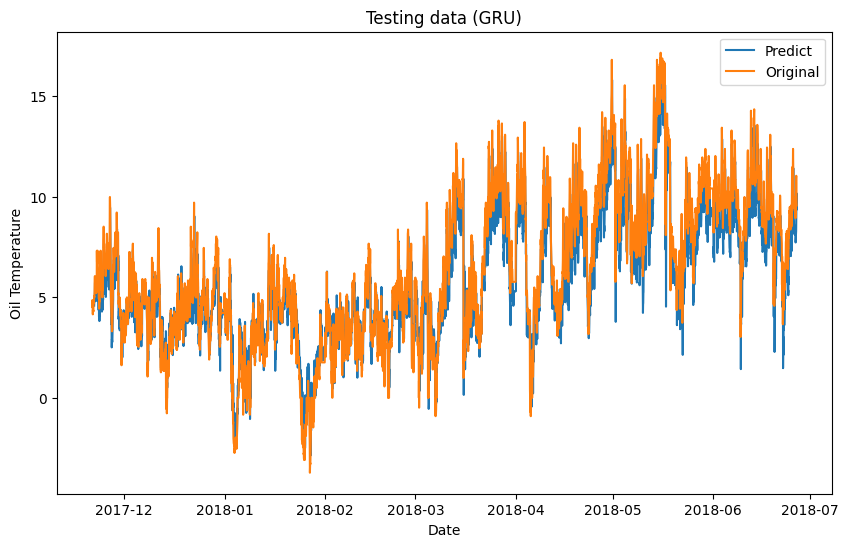

RMSE:  1.0799073512655828
MSE:  1.1661998873174468
MAE:  0.8812420606038391
R2:  0.9130983433379274


,RMSE,MSE,MAE,R2
0,1.079907,1.1662,0.881242,0.913098


In [15]:
y_test_pred_draw = np.empty(len(y_test_pred)+time_step+1)
y_test_pred_draw[:] = np.nan
y_test_pred_draw[time_step+1:len(y_test_pred_draw)+time_step+1] = y_test_pred

plt.figure(figsize=(10,6))
plt.plot(test_date, y_test_pred_draw, label= 'Predict')
plt.plot(test_date, np.array(test_data)[:,0], label= 'Original')
plt.ylabel("Oil Temperature")
plt.xlabel("Date")
plt.title("Testing data (GRU)")
plt.legend()
plt.show()

evaluation(y_test_draw, y_test_pred)